## Useful Functions ##

In [ ]:
import scipy
import scipy.sparse as sparse
import scipy.sparse.linalg as spalin
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt


def gen_s0sxsysz(L):
    sx = sparse.csr_matrix([[0., 1.],[1., 0.]])
    sy = sparse.csr_matrix([[0.,-1j],[1j,0.]])
    sz = sparse.csr_matrix([[1., 0],[0, -1.]])
    s0_list =[]
    sx_list = []
    sy_list = []
    sz_list = []
    I = sparse.eye(2**L, format='csr', dtype='complex')
    for i_site in range(L):
        if i_site==0:
            X=sx
            Y=sy
            Z=sz
        else:
            X= sparse.csr_matrix(np.eye(2))
            Y= sparse.csr_matrix(np.eye(2))
            Z= sparse.csr_matrix(np.eye(2))

        for j_site in range(1,L):
            if j_site==i_site:
                X=sparse.kron(X,sx, 'csr')
                Y=sparse.kron(Y,sy, 'csr')
                Z=sparse.kron(Z, sz,'csr')
            else:
                X=sparse.kron(X,np.eye(2),'csr')
                Y=sparse.kron(Y,np.eye(2),'csr')
                Z=sparse.kron(Z,np.eye(2),'csr')
        sx_list.append(X)
        sy_list.append(Y)
        sz_list.append(Z)
        s0_list.append(I)

    return s0_list, sx_list,sy_list,sz_list


def gen_op_total(op_list):
    L = len(op_list)
    tot = op_list[0]
    for i in range(1,L):
        tot = tot + op_list[i]
    return tot

def gen_op_prod(op_list):
    L= len(op_list)
    P = op_list[0]
    for i in range(1, L):
        P = P*op_list[i]
    return P

def gen_interaction_kdist(op_list, op_list2=[],k=1, bc='obc'):
    L= len(op_list)

    if op_list2 ==[]:
        op_list2=op_list
    H = sparse.csr_matrix(op_list[0].shape)
    Lmax = L if bc == 'pbc' else L-k
    for i in range(Lmax):
        H = H+ op_list[i]*op_list2[np.mod(i+k,L)]
    return H

def gen_state_bloch(thetaList, phiList):
    L=len(thetaList)
    psi = np.kron([np.cos(thetaList[0]/2.),np.exp(1j*phiList[0])*np.sin(thetaList[0]/2.)],
                  [np.cos(thetaList[1]/2.),np.exp(1j*phiList[1])*np.sin(thetaList[1]/2.)])
    for i in range(2,L):
        psi = np.kron(psi, [np.cos(thetaList[i]/2.),np.exp(1j*phiList[i])*np.sin(thetaList[i]/2.)])
    return psi

In [ ]:
from mpl_toolkits.axes_grid1 import AxesGrid
def heatmap2d(arr: np.ndarray):
    # define axes grid
    fig = plt.figure(frameon=False,figsize=(12, 8))
    fig.subplots_adjust(top=0.95)
    grid = AxesGrid(
        fig, 111,
        nrows_ncols=(1, 2),
        axes_pad=0.5,
        cbar_mode='each',
        cbar_location='right',
        cbar_pad=0.1
    )
    # plot
    real_image = grid[0].imshow(np.real(arr), cmap='plasma')
    grid[0].set_title("Real Part of matrix, $\Re{(M)}$", fontsize=20)
    imag_image = grid[1].imshow(np.imag(arr), cmap='plasma')
    grid[1].set_title("Imaginary Part of matrix, $\Im{(M)}$", fontsize=20)
    cbar = grid.cbar_axes[0].colorbar(real_image)
    cbar = grid.cbar_axes[1].colorbar(imag_image)
    plt.show()

## Question 1: Random Matrices  [25 pts] ##

A longstanding problem in quantum dynamics involves finding quantum analogs of classical concepts such as “chaos” and “ergodicity”. In classical dynamical systems, non-linear equations of motion can lead to chaotic trajectories that ergodically explore all of phase space. In this context, chaos means that trajectories display an exquisite sensitivity so that small differences in initial conditions get amplified in time exponentially at a rate set by a ‘Lyapunov exponent’ $\lambda$ – a manifestation of the so-called ‘butterfly effect’.

In contrast, quantum systems are governed by Schrodinger’s equation, which is linear, and hence cannot give rise to the kind of chaotic dynamics responsible for classical ergodicity. Under unitary evolution, the ‘distance’ between different time-evolving wavefunctions (measured, for instance, via the overlap) remains constant in time. Thus, new measures are needed to characterize chaos. One such measure that has been used to great effect is furnished by studying the eigenspectrum statistics of quantum systems with bounded spectra. The quantum chaos conjecture posits that the statistics of eigenspectra in chaotic Hamiltonians is universal and described by random matrix theory (RMT).

In the 1950's, Wigner introduced the idea of using RMT to describe the spectra of complex heavy atomic nuclei. In the decades since, the connection between chaos and RMT has been put on firm footing for single-particle systems in a semi-classical limit (Berry; Bohigas, Gianni, Schmit..).

In contrast, the emergence of RMT in many-body strongly quantum systems far from any semiclassical limit is still an active area of inquiry (some results on this for special models only within the last 2-3 years). It is truly remarkable that a sparse non-random matrix representing a physical, local Hamiltonian can share universal spectral properties with dense, random matrices.


While one can look at many different features to probe random matrix eigenspectra, one common measure is to look at the distribution of energy differences between nearest-neighbor-in-energy eigenstates. This is a probe of `level repulsion' in the system. The first task at hand is to understand the distributions of level spacings.

According to the Wigner surmise, we only need to study 2x2 matrices in the right `symmetry class' to obtain distributions that will also apply (to a good approximation) to large $NxN$ random matrices.

Let's start by looking at the distribution of level spacings for a 2x2 real, symmetric Hamiltonian with matrix elements drawn from the Gaussian ensemble ("GOE = Gaussian Orthogonal Ensemble"). The normalized distrubutions of level spacings takes the form:
$P(s) = a_\beta s^\beta e^{-b_\beta s^2}$ where $a_\beta, b_\beta$ are constants and $\beta = 1 \;(GOE),\; 2 \;(GUE)$. These constants are chosen to ensure two conditions:



*   the distribution is normalized: $\int_0^\infty ds P(s) = 1$ and  
*   the average level spacing is 1: $\langle s \rangle = \int_0^\infty ds\; s P(s) = 1$. (the discussion on spectral unfolding below discusses why this is done).




a) The constants are $\{a_1 = \pi/2, b_1 = \pi/4\}$ for GOE and $\{a_2 = 32/\pi^2, b_2 = 4/\pi\}$ for GUE. Verify by explicit integration that the normalization and $\langle s \rangle =1$ conditions are satisfied for both the GOE and GUE distributions. [2pts]


b) Generate $2x2$ random matrices drawn from the GOE ensemble. Compute the eigenvalues $\epsilon_1, \epsilon_2$ and the spacing $s = \epsilon_2 - \epsilon_1$. Do this for many samples, say $M=3000$ and plot the normalized histogram of $s$ across these samples. The function plt.hist with argument `density = True' is helpful.
Compare against the analytic prediction for $P(s)$ by plotting $P(s)$ on the same plot as the histogram. **Remember that $\langle s \rangle = 1$ for $P(s)$ so you  need to divide your list of spacings by the average before histogramming to get agreement**.  [4pts]

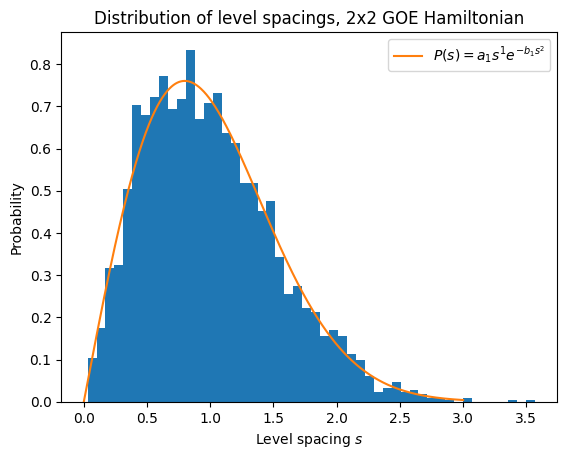

In [ ]:
#Run m trials of generating random 2x2 GOE matrices and computing level spacing
def goe2by2(m):
  s = []
  for i in range(m):
    mat = np.random.randn(2, 2)
    sym = 0.5 * (mat + mat.T)
    eigs = linalg.eigh(sym, eigvals_only=True)
    diff = eigs[1] - eigs[0]
    s.append(diff)
  return s / (sum(s)/len(s))

def levelspacingdist(s, a= np.pi/2, b=np.pi/4):
  return a*s*np.exp(-b*s**2)

x = np.linspace(0, 3, 1000)

plt.hist(goe2by2(3000), bins=50, density=True)
plt.plot(x, levelspacingdist(x), label= r'$P(s) = a_1 s^1 e^{-b_1 s^2}$')
plt.title('Distribution of level spacings, 2x2 GOE Hamiltonian')
plt.xlabel('Level spacing $s$')
plt.ylabel('Probability')
plt.legend()

Now let us look at the spectrum of a large $NxN$ random matrix, again drawn from the GOE ensemble. We will see how the distrubution of level spacings agrees remarkably well with the 2x2 answer! Pick $N = 3000$, create a $NxN$ random GOE matrix and obtain its eigenvalues.

(c) Plot the histogram of eigenvalues (i.e. DOS). This should display the Wigner semicircle shape. [2pts]

(d) Choose the middle third of the eigenvalues, obtain the spacings between the eigenvalues and divide by the average spacing so that $\langle s \rangle$ =1. Plot a normalized histogram of these spacings, and superpose the Wigner surmise prediction obtain for $2x2$ matrices. [2pts]

Text(0.5, 0, 'Energy')

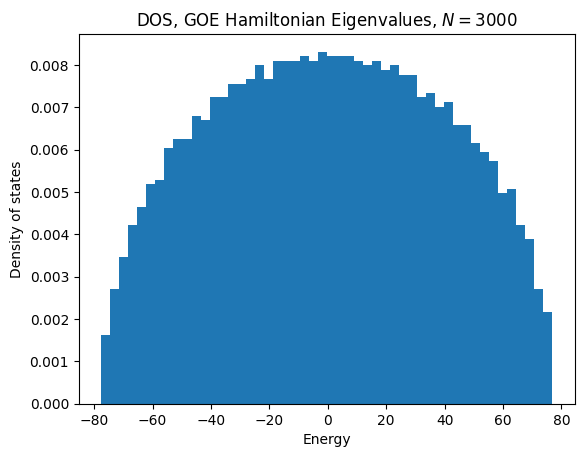

In [ ]:
def genGOE(N):
  mat = np.random.randn(N,N)
  sym = 0.5 * (mat + mat.T)
  eigs = linalg.eigh(sym, eigvals_only=True)
  return eigs
eigsGOE3000 = genGOE(3000)
plt.hist(eigsGOE3000, bins=50, density=True)
plt.title('DOS, GOE Hamiltonian Eigenvalues, $N = 3000$')
plt.ylabel('Density of states')
plt.xlabel('Energy')

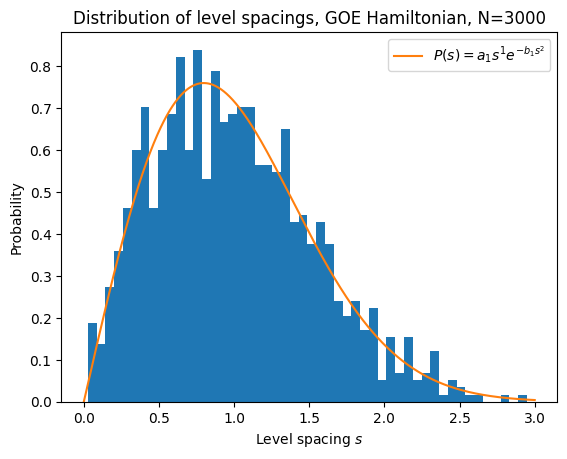

In [ ]:
midSpectrum = eigsGOE3000[1000:2000]
diffs = []
for i in range(len(midSpectrum) - 1):
  diffs.append(midSpectrum[i+1] - midSpectrum[i])
diffs = diffs / (sum(diffs)/len(diffs))
plt.hist(diffs, bins=50, density=True)
plt.plot(x, levelspacingdist(x), label= r'$P(s) = a_1 s^1 e^{-b_1 s^2}$')
plt.title('Distribution of level spacings, GOE Hamiltonian, N=3000')
plt.xlabel('Level spacing $s$')
plt.ylabel('Probability')
plt.legend()

One annoying technicality in all studies of RMT is the need for `spectral unfolding'. We want to compare energy spacing distributions across different models to search for universality. This requires specific details to be removed (such as dependences on system size, energy density etc.), so that the average level spacing is unity. In practice, prescriptions for unfolding can be quite ad-hoc and results sometimes end up being sensitive to the prescription used. We used a "poor man's" unfolding prescription above when we divided by $\langle s \rangle$, but there are entire PhD theses written on unfolding prescriptions!



To circumvent this issue, it is often convenient to use a different measure called the r-ratio, introduced by Oganesyan and Huse, which is the ratio of consecutive energy-level spacings:
$\tilde{r_n} = \frac{{\rm min} \{s_n, s_{n-1}\}}{{\rm max} \{s_n, s_{n-1}\}} $. By taking the ratio of consecutive spacings, overall scales get modded out.

Useful Reference: Atas et. al., "The distribution of the ratio of consecutive level spacings in random matrix ensembles", https://arxiv.org/pdf/1212.5611.pdf.

(e) Obtain the distributions of $\tilde{r}$ for 3x3 and $NxN$ random matrices drawn from the GOE ensemble, and compare against the analytic prediction in Atas et. al. Note that you need 3x3 matrices because you need two spacings and hence three eigenvalues. [5pts]




<function len(obj, /)>

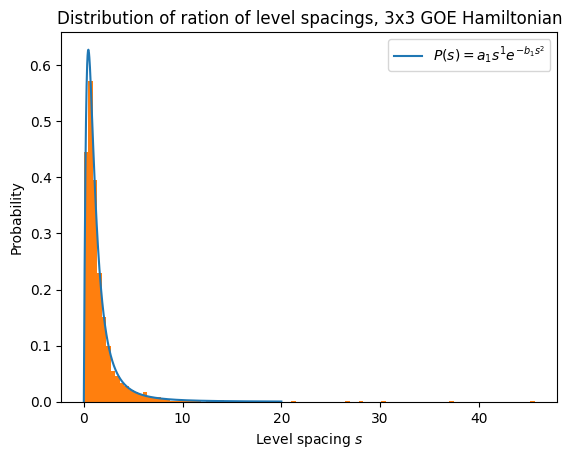

In [ ]:
#Run m trials of generating random NxN GOE matrices and computing ratios of level spacings
def r_goeNxN(m,N):
  rtilde = []
  r_ = []
  for i in range(m):
    diffs = []
    mat = np.random.randn(N, N)
    sym = 0.5 * (mat + mat.T)
    eigs = linalg.eigh(sym, eigvals_only=True)
    #compute level spacings for each trial
    for j in range(len(eigs) - 1):
      diffs.append(eigs[j+1] - eigs[j])
    #compute ratios
    for k in range(len(diffs) - 1):
      r = diffs[k+1]/diffs[k]
      rtilde.append(min([r, 1/r]))
      r_.append(r)
  return rtilde, r_

def rdist(r):
  return (27/8)* (r + r**2) / (1 + r + r**2)**(2.5)

r = np.linspace(0, 20, 1000)

plt.plot(r, rdist(r), label= r'$P(s) = a_1 s^1 e^{-b_1 s^2}$')
plt.hist(r_goeNxN(3000, 3)[1], bins=100, density=True)
plt.title('Distribution of ration of level spacings, 3x3 GOE Hamiltonian')
plt.xlabel('Level spacing $s$')
plt.ylabel('Probability')
plt.legend()
len

Text(0, 0.5, 'Probability')

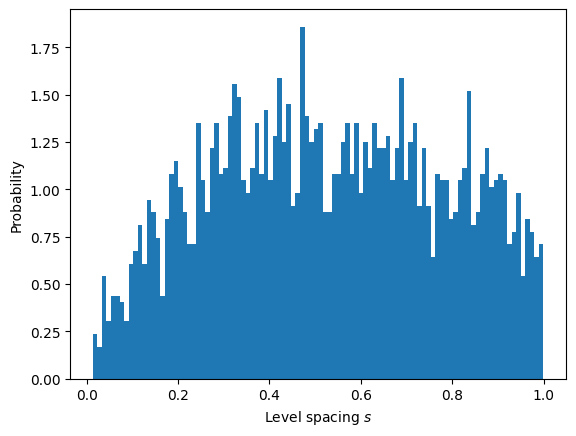

In [ ]:
plt.hist(r_goeNxN(3000, 3)[0], bins=100, density=True)
plt.xlabel('Level spacing $s$')
plt.ylabel('Probability')



(f) Analytically derive the distributions of level spacings for 2x2 GOE random matrices (i.e. the Wigner surmise). Hint: the entries of the matrix are drawn from Gaussian normal distributions, and the distributions of eigenvalues can be obtained via a suitable change of basis and the accompanying Jacobian. [5pts]

(g) Following Atas et. al., analytically derive the distribution of $\tilde{r}$ for the GOE ensemble (this is a generalization of the Wigner surmise which requires you to consider 3x3 matrices). [5pts]


## Question 2: Diagonalizing with symmetries [20 pts] (+ Bonus 20pts)##

When a Hamiltonian has a symmetry $S$ so that $[H, S]=0$, it can often help with diagonalization to take this symmetry into account. Because $H$ and $S$ can be simultaneously diagonalized, $H$ is block diagonal in the basis of eigenstates of $S$. Because these block sizes are smaller than the size of the full Hilbert space, diagonalizing the blocks separately can substantially speed up diagonalization. Remember that (dense) diagonalization scales with matrix size as $N^3$. Thus, if we can divide the Hamiltonian of size $2^L$ into (say) two equal blocks of size $(2^L)/2$, each of the two blocks will be diagonalized 8 times faster, for a total factor of 4 speedup in the diagonalization.

The block diagonalization is only useful if the symmetries $S$ are "simple", so that the eigenstates of $S$ can be obtained without doing an explicit diagonalization for $S$. For example, when $S = \prod_i Z_i$, we know the eigenstates of $S$ are just product states in the $Z$ basis. Doing a dense diagonalization of $S$ is not useful numerically, because it is just as expensive as doing full diagonalization on $H$.

To block diagonalize the Hamiltonian in the eigenbasis of $S$, one obtains the eigenvalues of $S$ (again, these are often known analytically): $\{s_1, s_2, \cdots s_n\}$. We then construct projectors $P_\alpha$ whose columns are the eigenvectors of $S$ with a given eigenvalue $s_\alpha$. This matrix has dimension $2^L x d_\alpha$, where $d_\alpha$ is the number of eigenstates of $S$ with eigenvalue $s_\alpha$. Finally, $H_\alpha = P^T_\alpha  H P_\alpha$ has dimension $d_\alpha x d_\alpha$ and can be diagonalized more efficiently. Finally, note that $H$ and $P_\alpha$ are sparse matrices in most cases of interest, so $H_\alpha$ can be constructed using sparse multiplication.  

Of course, when $H$ has multiple mutually commuting symmetries, the blocks can be chosen to take all of these into account.

Useful reference: http://physics.bu.edu/~sandvik/nccu/l2.pdf



Choose $L = 8$.


(a) Pick $S = \prod_{i=1}^L Z_i$. This has eigenvalues $\{+1, -1\}$. Construct $P_+$ and $P_-$ without doing dense diagonalization. Note that you can do this by explictly looping through all $2^L$ $z$ basis states in binary, and computing $S$ for each of these. However, it is even faster to directly construct the diagonal matrix $S$ using sparse multiplication. Then you can obtain the diagonal entries using S.diagonal(), and search for the indices where the entries are +1 or -1 using np.where(). [2pts]

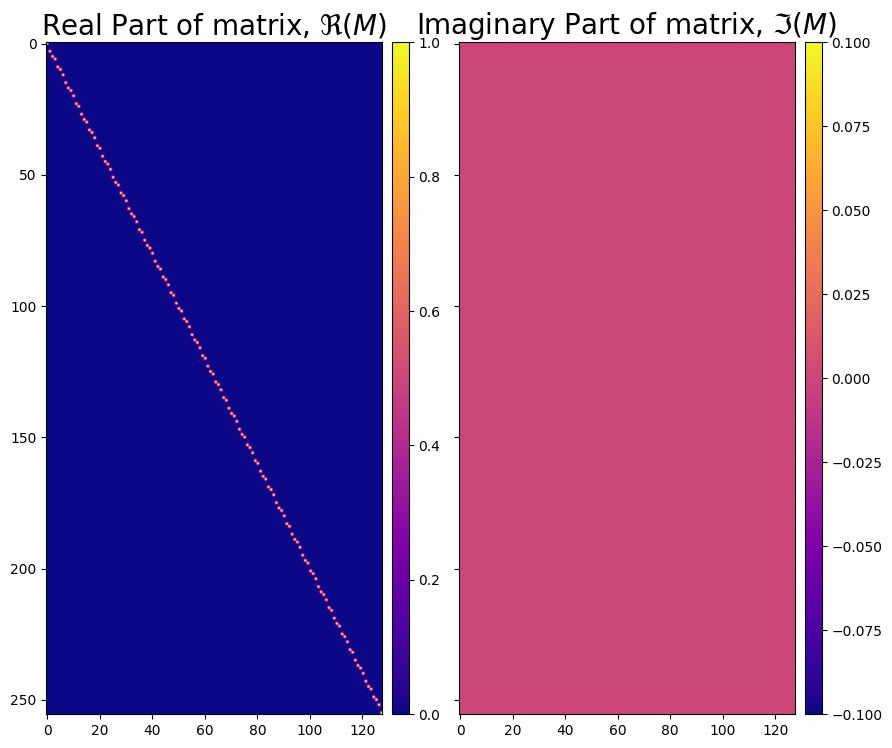

In [ ]:
L = 8
s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)
S = gen_op_prod(sz_list)
Sdiag = S.diagonal()
plusInds = np.where(Sdiag == 1)[0]
minusInds = np.where(Sdiag == -1)[0]
Pplus = np.vstack([np.eye(1, len(Sdiag), k=i)[0] for i in plusInds]).T
Pminus = np.vstack([np.eye(1, len(Sdiag), k=i)[0] for i in minusInds]).T
heatmap2d(Pplus)



(b) Pick $S = \sum_i Z_i$. What are the possible eigenvalues $s_\alpha$ of $S$? Construct $P_\alpha$ for each of these. Once again, looking at the diagonal entries of $S$ may be useful. [3pts]

> Each $Z_i$ has eigenvalue +1 and -1, so the possible eigenvalues are the even integers from -SL to SL: $-SL, -S(L-2), \dots, S(L-2), SL$. Again the eigenstates are just the $Z$ basis product states.

In [ ]:
S2 = gen_op_total(sz_list)
S2diag = S2.diagonal()
S2diag

array([ 8.,  6.,  6.,  4.,  6.,  4.,  4.,  2.,  6.,  4.,  4.,  2.,  4.,
        2.,  2.,  0.,  6.,  4.,  4.,  2.,  4.,  2.,  2.,  0.,  4.,  2.,
        2.,  0.,  2.,  0.,  0., -2.,  6.,  4.,  4.,  2.,  4.,  2.,  2.,
        0.,  4.,  2.,  2.,  0.,  2.,  0.,  0., -2.,  4.,  2.,  2.,  0.,
        2.,  0.,  0., -2.,  2.,  0.,  0., -2.,  0., -2., -2., -4.,  6.,
        4.,  4.,  2.,  4.,  2.,  2.,  0.,  4.,  2.,  2.,  0.,  2.,  0.,
        0., -2.,  4.,  2.,  2.,  0.,  2.,  0.,  0., -2.,  2.,  0.,  0.,
       -2.,  0., -2., -2., -4.,  4.,  2.,  2.,  0.,  2.,  0.,  0., -2.,
        2.,  0.,  0., -2.,  0., -2., -2., -4.,  2.,  0.,  0., -2.,  0.,
       -2., -2., -4.,  0., -2., -2., -4., -2., -4., -4., -6.,  6.,  4.,
        4.,  2.,  4.,  2.,  2.,  0.,  4.,  2.,  2.,  0.,  2.,  0.,  0.,
       -2.,  4.,  2.,  2.,  0.,  2.,  0.,  0., -2.,  2.,  0.,  0., -2.,
        0., -2., -2., -4.,  4.,  2.,  2.,  0.,  2.,  0.,  0., -2.,  2.,
        0.,  0., -2.,  0., -2., -2., -4.,  2.,  0.,  0., -2.,  0

In [ ]:
def genP(alpha, diagvec):
  inds = np.where(diagvec == alpha)[0]
  return np.vstack([np.eye(1, len(diagvec), k=i)[0] for i in inds]).T

In [ ]:
Palphas = []
for alpha in np.arange(-L, L+2, 2):
  p = genP(alpha, S2diag)
  Palphas.append(p)
  print(f'alpha = {alpha}, P_{alpha}$ = {p}')


(c) Pick $S = \prod_i X_i$. Construct $P_+$ and $P_-$ without doing dense diagonalization. [5pts]


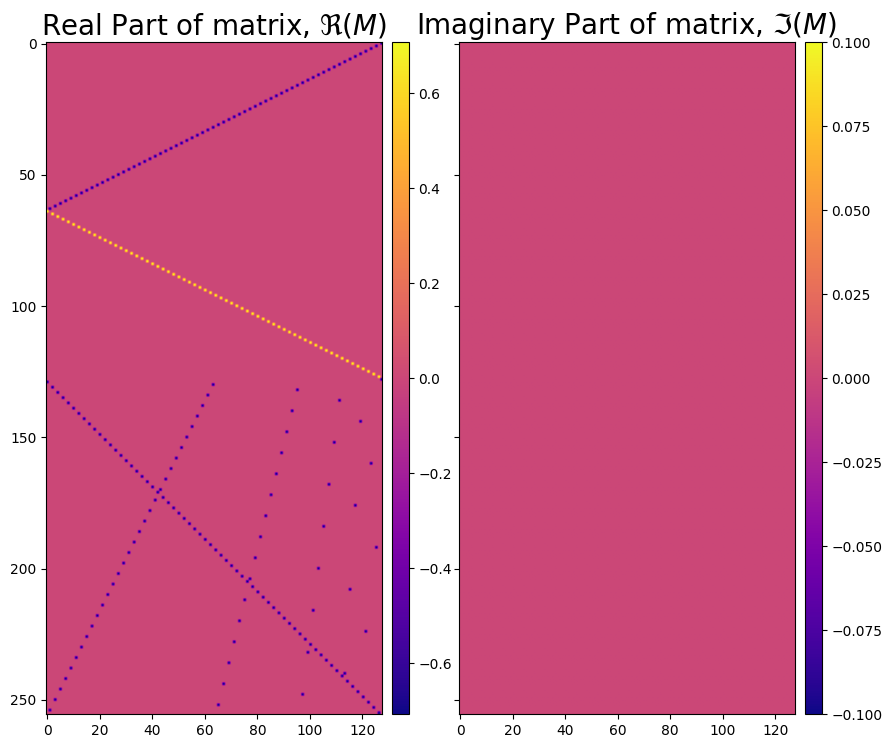

In [ ]:
evals, evecs = linalg.eigh(gen_op_prod(sx_list).toarray())
plusInds = np.where(evals == 1)[0]
minusInds = np.where(evals == -1)[0]
Pplus = np.vstack([evecs[i] for i in range(128, 256)]).T
Pminus = np.vstack([evecs[i] for i in range(0,128)]).T
heatmap2d(Pplus)

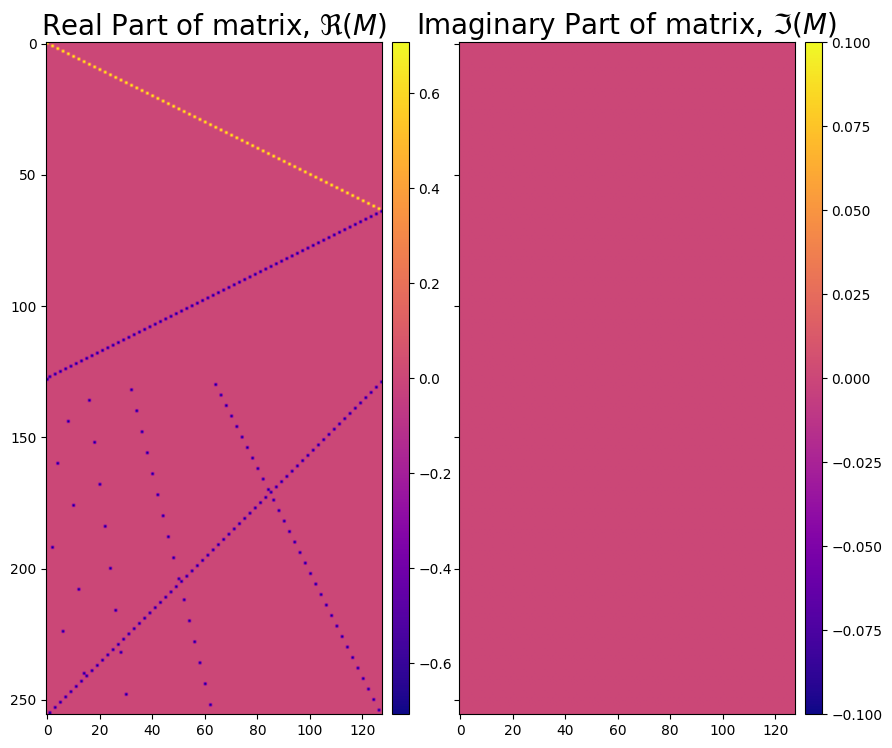

In [ ]:
heatmap2d(Pminus)


(d) Pick $S$ = spatial inversion symmetry. Construct $P_+$ and $P_-$. [10pts]

(e) Bonus: Pick $S$ = discrete translation symmetry by a lattice constant. What are the allowed eigenvalues? Construct $P_\alpha$ for each of these. The Sandvik link above will be useful. [20pts]  

## Question 3: $J_1$-$J_2$ Heisenberg model [30 pts]##

A class of models we'll use very often in this course are perturbations of the integrable XXZ chain: $H = J \sum_i (\sigma_i^x\sigma_{i+1}^x + \sigma_i^y\sigma_{i+1}^y + \Delta_z\sigma_i^z\sigma_{i+1}^z)$. The model is integrable for all $\Delta_z$, but $\Delta_z = 1$ has $SU(2)$ symmetry which complicates the ETH analysis. For simplicity, set $\Delta_z =0.5$.
One integrability breaking perturbation is the addition of second-neighbor hoppings/interactions:
$$H = J \sum_i (\sigma_i^x\sigma_{i+1}^x + \sigma_i^y\sigma_{i+1}^y + \Delta_z \sigma_i^z\sigma_{i+1}^z) + J_2 \sum_i (\sigma_i^x\sigma_{i+2}^x + \sigma_i^y\sigma_{i+2}^y + \Delta_z \sigma_i^z\sigma_{i+2}^z).$$ Note that this model has an additional $U(1)$ symmetry corresponding to conservation of total $z$ component of spin, $Q = S^z_{\rm tot} = \sum_i \sigma_i^z$.  The Hamiltonian in the $z$ basis is block diagonal in the different sectors of $Q$, since it cannot mix between states with different $q$ values.


We will take $Q$ into account in the analysis below. However, to simplify the numerical analysis, you can work with open boundary conditions (so that you do not have translation symmetry). You may also choose to add a small boundary term $0.2 \sigma_1^z$; this will not change the bulk properties, but breaks inversion symmetry so your analysis is not complicated by inversion symmetry.

We will compare two Hamiltonians:
$J_2 = 0$ which is integrable and
$J_2 = 1$ which is non-integrable. The parts below will require you to analyse various eigenspectrum properties for both values of $J_2$ and $L = 8, 10, 12, 14$. I suggest diagonalizing once for each parameter choice (take the $Q$ symmetry into account) and then performing the different analyses below, rather than diagonalizing separately each time.  


(a) Consider the entire (sorted) eigenvalue spectrum for $H$. You can obtain this by merging the eigenvalues from each sector into a single list, and sorting this list. Consider the middle third of the sorted list of eigenvalues (corresponding to infinite temperature) and obtain and plot the distribution of eigenenergy spacings for both values of $J_2$ and the different $L$ values. Do you notice a difference between the integrable and non-integrable cases? [10pts]


> For fun, we can take a look at the block diagonal structure of the Hamiltonian visually.

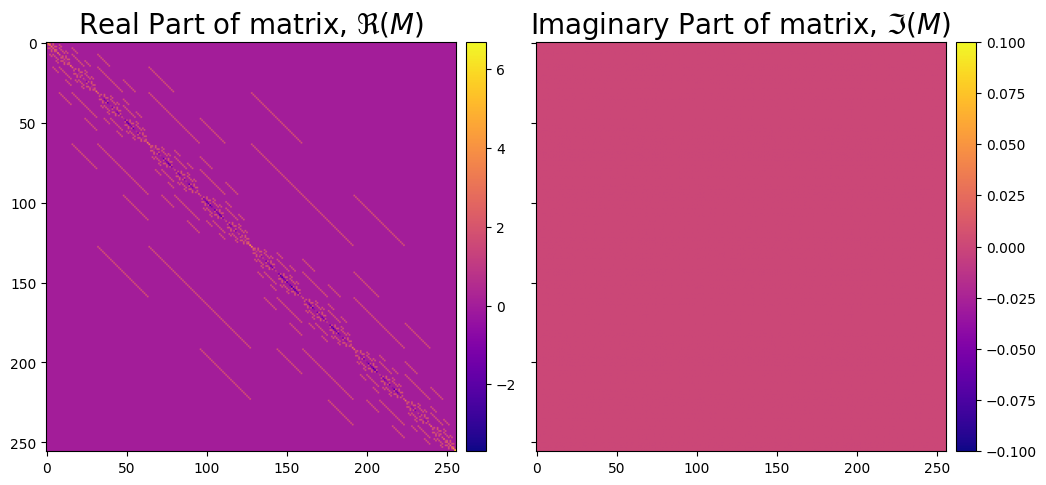

In [ ]:
def H(L,  J2, J1=1, dz=0.5):
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)
  return J1*(gen_interaction_kdist(sx_list)+gen_interaction_kdist(sy_list)+dz*gen_interaction_kdist(sz_list)) + J2*(gen_interaction_kdist(sx_list, k=2)+gen_interaction_kdist(sy_list, k=2) + dz*gen_interaction_kdist(sz_list, k=2)) + 0.2*sz_list[0]
heatmap2d(H(L=8,J2 =1).toarray())

In [ ]:
#Function to generate the full spectrum and eigenenergy spacings of our perturbed XXZ Hamiltonian
def genSpectrum(L, J2):
  #Gen full hamiltonian
  rawH = H(L,  J2, J1=1, dz=0.5)
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)

  #Gen Q and Q eigenvalues
  Q = gen_op_total(sz_list)
  Qdiag = Q.diagonal()
  #Construct P_alpha projectors for each sector, and diagonalize each block of H
  Palphas = []
  eval_list = []
  for alpha in np.arange(-L, L+2, 2):
    p = genP(alpha, Qdiag)
    Palphas.append(p)
    H_alpha = p.T @ rawH @ p
    evals_, evecs_ = linalg.eigh(H_alpha)
    [eval_list.append(evals_[i]) for i in range(len(evals_))]
    sortedevals = sorted(eval_list)
  #return sorted list of evals and eval differences
  return sortedevals, np.diff(sortedevals)


In [ ]:
evals_8_1 = genSpectrum(8, 1)
evals_8_0 = genSpectrum(8, 0)
evals_10_1 = genSpectrum(10, 1)
evals_10_0 = genSpectrum(10, 0)

In [ ]:
evals_12_1 = genSpectrum(12, 1)
evals_12_0 = genSpectrum(12, 0)

In [ ]:
evals_14_0 = genSpectrum(14, 0)

In [ ]:
evals_14_1 = genSpectrum(14, 1)

In [ ]:
def plotSpacings(diffs, L, J2, numbins=50):
  n = len(diffs)
  scaleddiffs = diffs / (sum(diffs)/n)
  mid = scaleddiffs[int(n/3):int(2*n/3)]
  fig, ax = plt.subplots()
  ax.hist(mid, bins=numbins, density=False)
  ax.set(title=f'Distribution of Eigenenergy Spacings, L = {L}, J2 = {J2}', xlabel='Level spacings', ylabel='Density')

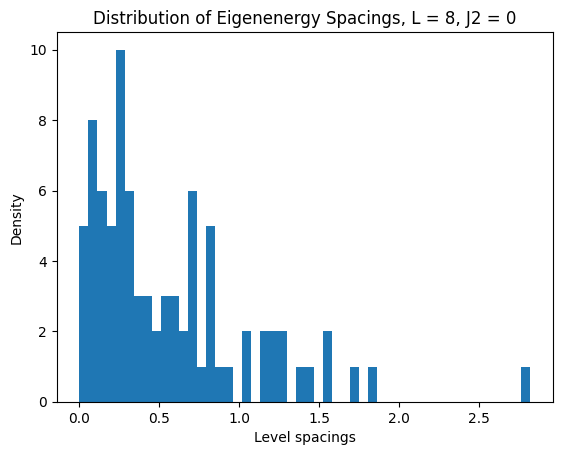

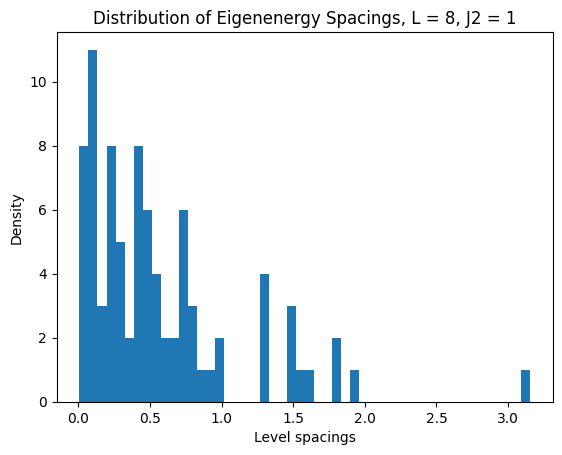

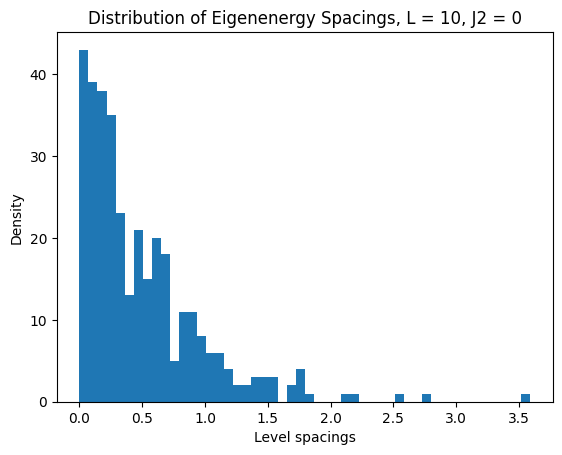

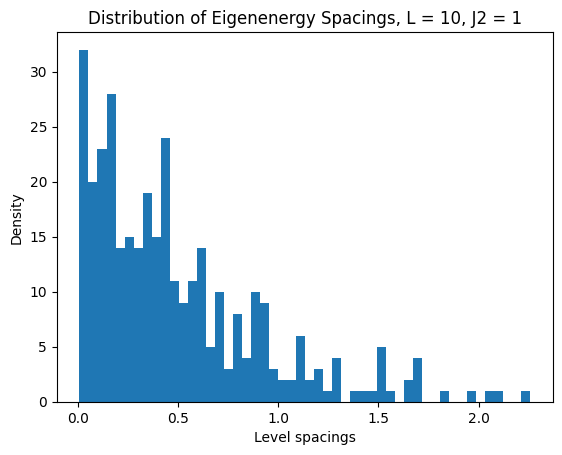

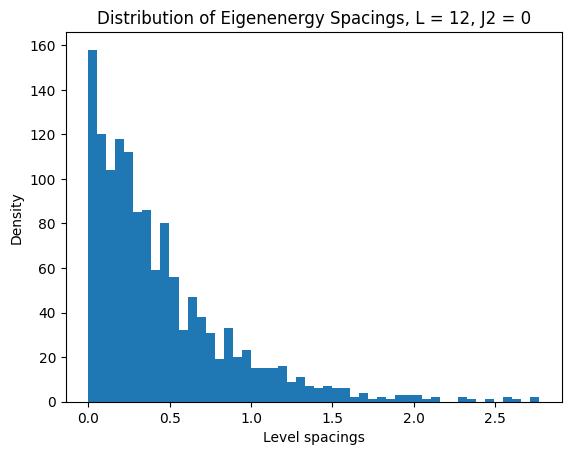

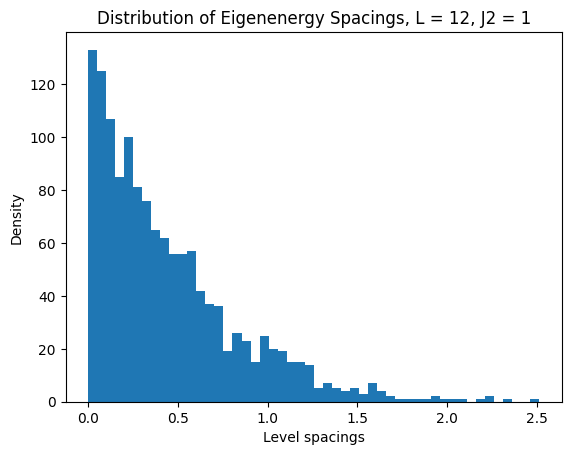

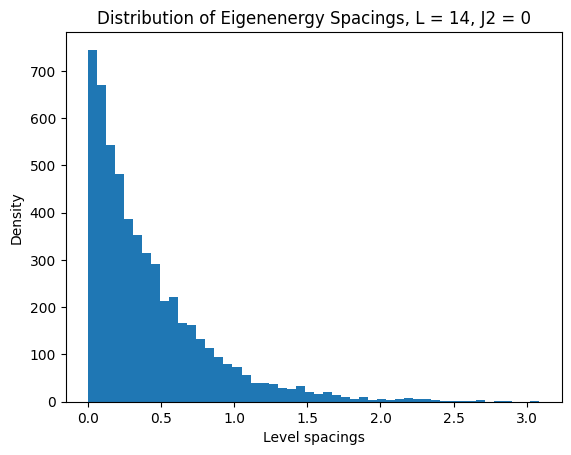

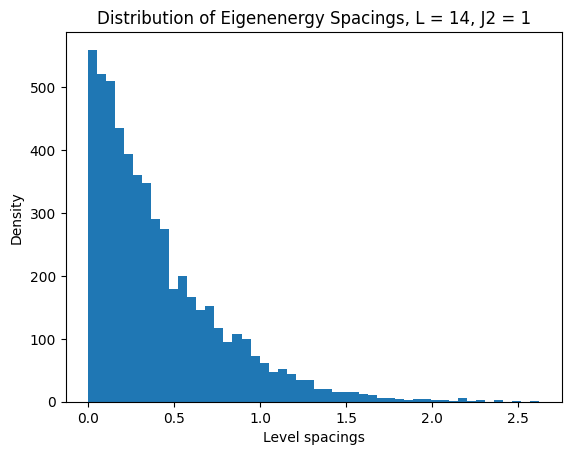

In [ ]:
plotSpacings(evals_8_0[1], 8, 0)
plotSpacings(evals_8_1[1], 8, 1)

plotSpacings(evals_10_0[1], 10, 0)
plotSpacings(evals_10_1[1], 10, 1)

plotSpacings(evals_12_0[1], 12, 0)
plotSpacings(evals_12_1[1], 12, 1)

plotSpacings(evals_14_0[1], 14, 0)
plotSpacings(evals_14_1[1], 14, 1)

> We do notice a difference between the integrable and non integrable cases. In the J2 = 0 case we observe a faster drop off in the distribution of energy spacings.


(b) Repeat the analysis from (a), but now only consider eigenvalues within the $Q=0$ symmetry sector. What changed? [5pts]

In [ ]:
#Function to generate the full spectrum and eigenenergy spacings of our perturbed XXZ Hamiltonian
def genSpectrumQ0(L, J2):
  #Gen full hamiltonian
  rawH = H(L,  J2, J1=1, dz=0.5)
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)

  #Gen Q and Q eigenvalues
  Q = gen_op_total(sz_list)
  Qdiag = Q.diagonal()
  #Construct P_0 projectors
  for alpha in [0]:
    p = genP(alpha, Qdiag)
    Palphas.append(p)
    H_alpha = p.T @ rawH @ p
    evals_, evecs_ = linalg.eigh(H_alpha)
    [eval_list.append(evals_[i]) for i in range(len(evals_))]
    sortedevals = sorted(eval_list)
  #return sorted list of evals and eval differences
  return sortedevals, np.diff(sortedevals)


In [ ]:
Q0_evals_8_1 = genSpectrumQ0(8, 1)
Q0_evals_8_0 = genSpectrumQ0(8, 0)
Q0_evals_10_1 = genSpectrumQ0(10, 1)
Q0_evals_10_0 = genSpectrumQ0(10, 0)
Q0_evals_12_1 = genSpectrumQ0(12, 1)
Q0_evals_12_0 = genSpectrumQ0(12, 0)

In [ ]:
Q0_evals_14_1 = genSpectrumQ0(14, 1)
Q0_evals_14_0 = genSpectrumQ0(14, 0)

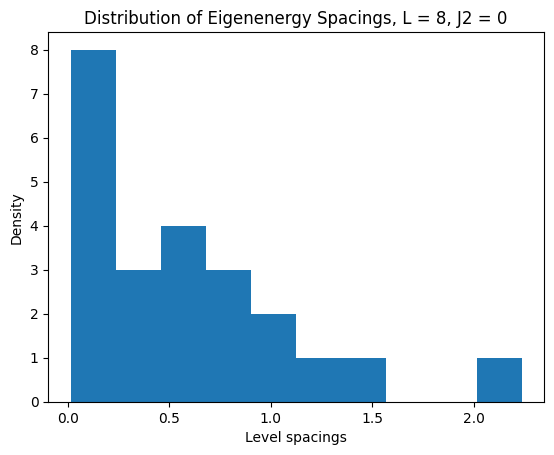

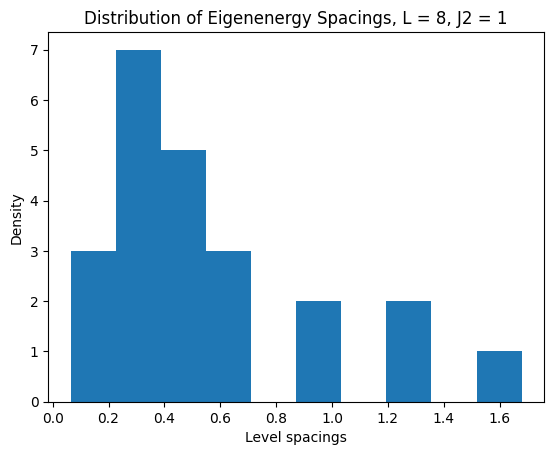

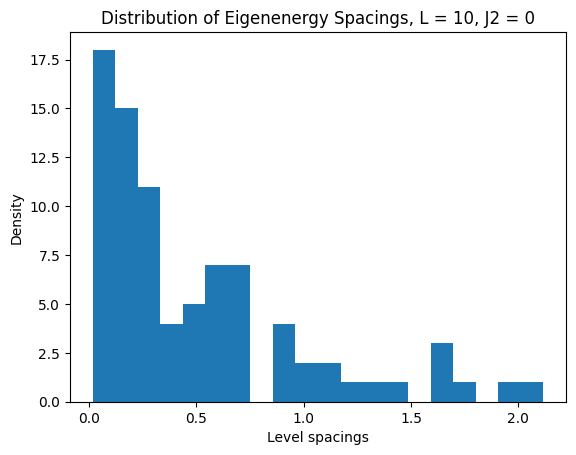

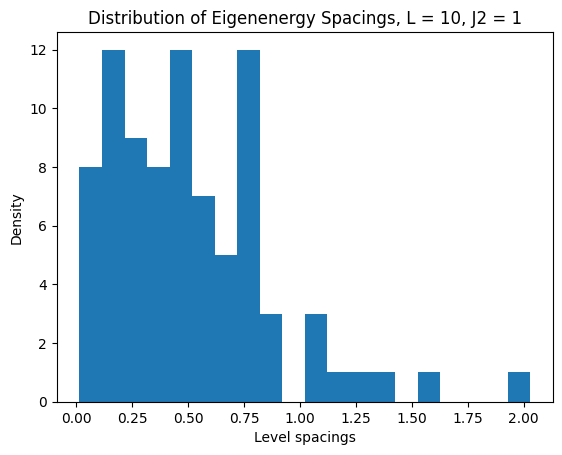

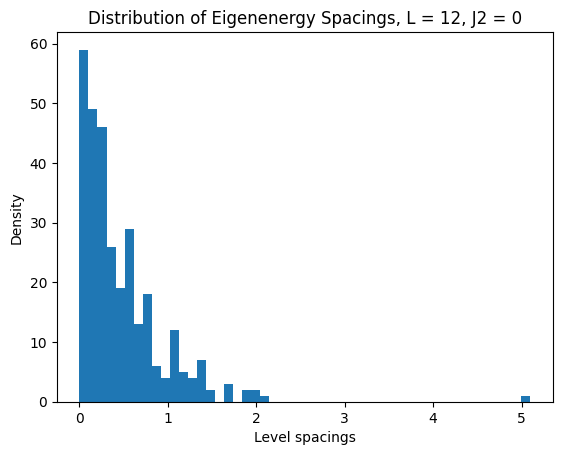

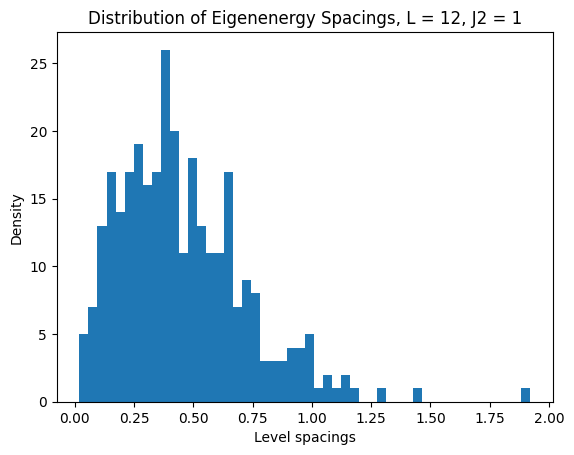

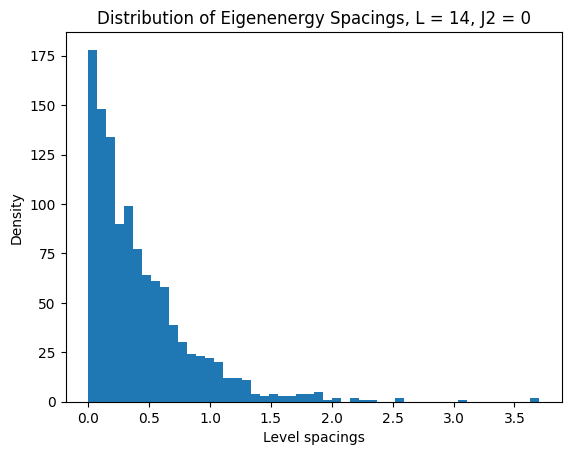

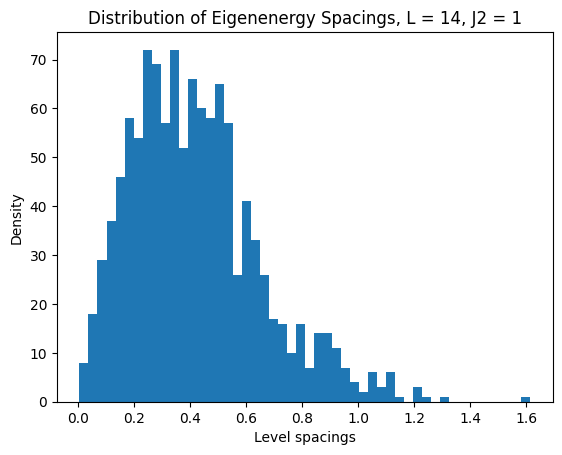

In [ ]:
plotSpacings(Q0_evals_8_0[1], 8, 0, numbins=10)
plotSpacings(Q0_evals_8_1[1], 8, 1, numbins=10)

plotSpacings(Q0_evals_10_0[1], 10, 0, numbins=20)
plotSpacings(Q0_evals_10_1[1], 10, 1, numbins=20)

plotSpacings(Q0_evals_12_0[1], 12, 0)
plotSpacings(Q0_evals_12_1[1], 12, 1)

plotSpacings(Q0_evals_14_0[1], 14, 0)
plotSpacings(Q0_evals_14_1[1], 14, 1)

> We find that in the non-integrable case J2=1, the distributions are now peaked around a nonzero value. The integrable case J2=0 still is peaked at 0, but decays faster than before.



(c) Comment on the results from (a) and (b), and discuss the importance of symmetries in performing analyses of eigenvalue spacings. [5pts]

> By using symmetries to isolate and diagonalize blocks within the sparse local, physical Hamiltonian, we greatly speed up the computation of the eigenspectrum since the Hilbert spaces become much smaller for each sector. As we found in pset 1, the maximum matrix diagonalization for a laptop like mine with 16 GB of RAM is L=14, not even considering time complexity. By first diagonalizing each block to obtain the energy eigenvalues, I was able to obtain a spectrum for L=14 in roughly 5 minutes with ~3 GB of RAM allocation.

Furthermore, in b we discovered that for integrable systems, the physics can be mostly captured by considering a single sector, which allows us another way to reduce our time and space to analyze spacings.

>


Recall the ETH ansatz: $O_{\alpha \beta} = O(E)\delta_{\alpha \beta} + R_{\alpha\beta} e^{S(E)/2}f(E,\omega)$, where $E= \frac{E_\alpha+E_\beta}{2}$ and $\omega = E_\beta - E_\alpha$, and O(E) and $f(E, \omega)$ are smooth functions of $E, \omega$, $R_{\alpha, \beta}$ is a Gaussian random variable.

The off-diagonal ETH ansatz follows from RMT. For a $N$ dimensional Gaussian random matrix, the eigenvectors $|\alpha\rangle$ look like random gaussian vectors. The eigenvectors have unit norm, which imposes that $\alpha_i \sim r_i /\sqrt{N}$, with $r_i$ a random Gaussian variable and $\alpha_i$ is the $i$th entry of $|\alpha\rangle$ in the computational basis. If $|\alpha\rangle$ is a random vector, so is $O|\alpha\rangle$, and the overlap of $O|\alpha\rangle$ with another random vector $|\beta\rangle$ typically scales as $r/\sqrt{N}$ (similar to scaling of $\alpha_i$, which is of course the overlap of the random vector $\alpha$ with the computational basis state $i$). This RMT expection shows up in the $R_{\alpha\beta} e^{-S(E)/2}$ part of the ETH ansatz, as $e^{-S(E)/2} \sim 1/\sqrt{N}$ is simply the inverse square root of the Hilbert space dimension at energy $E$. For small enough energy windows ($\Delta E < E_{\rm Thouless}$), the spectrum of a thermalizing Hamiltonian resembles that of a random matrix, and $f(E, \omega)$ is featureless.

We will now perform a crude test of off-diagonal ETH.

(d) Pick the largest system size $L=14$ and work within the $S^z_{\rm tot} = 0$ sector. (This is the largest sector corresponding to $\mu = 0$, analogous to working at infinite temperature). Pick the middle 100 eigenstates in the sector, and obtain $O_{\alpha \beta}$ for each pair of eigenstates within these 1000 states (this will give you 100 choose 2 = 4950 $O_{\alpha \beta}$ values). You can pick $O = Z_{L/2}$.  Histogram these matrix elements for both values of $J_2$. Do the distributions look Gaussian? This is testing the prediction that $R_{\alpha \beta}$ in the ETH ansatz is a random Gaussian variable.
Discuss the differences between the two values of $J_2$. [10pts]

An interesting paper and very readable paper that explores off-diagonal across an MBL phase transition is: https://arxiv.org/abs/1607.01012


Note: since we are only performing this analysis for a fixed system size, we are not checking for the $e^{-S/2}$ dependence; likewise, $f$ is assumed to be featureless within the small energy window we have picked.  Of course, you are welcome to explore there features as well.



In [ ]:
#Function to generate the full spectrum and eigenenergy spacings of our perturbed XXZ Hamiltonian
def genMiddle100_Q0(L, J2):
  #Gen full hamiltonian
  rawH = H(L,  J2, J1=1, dz=0.5)
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)

  #Gen Q and Q eigenvalues
  Q = gen_op_total(sz_list)
  Qdiag = Q.diagonal()
  #Construct P_alpha projectors for each sector, and diagonalize each block of H
  Palphas = []
  eval_list = []
  for alpha in [0]:
    p = genP(alpha, Qdiag)
    Palphas.append(p)
    H_alpha = p.T @ rawH @ p
    evals_, evecs_ = linalg.eigh(H_alpha)
    [eval_list.append(evals_[i]) for i in range(len(evals_))]
    #sortedevals, sortedevecs = sorted(eval_list)
  #return sorted list of evals and eval differences
  n = len(evals_)
  lowInd = int((n/2 - 50))
  highInd = int((n/2 + 50))
  return evals_[lowInd:highInd], evecs_[lowInd:highInd]


100

In [ ]:
evals100_1, evecs100_1 = genMiddle100_Q0(14,1)

In [ ]:
evals100_0, evecs100_0 = genMiddle100_Q0(14,0)

In [ ]:
evecs100_0

In [ ]:
s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(14)
#Gen Q and Q eigenvalues
Q = gen_op_total(sz_list)
Qdiag = Q.diagonal()
#Construct P_alpha projector Q=0 sector
p = genP(0, Qdiag)
O = p.T @ sz_list[6] @ p
matElems1 = []
matElems0 = []
for i in range(1,100):
  for j in range(i+1,100):
    matElems1.append(np.vdot(evecs100_1[i], O@evecs100_1[j]))
    matElems0.append(np.vdot(evecs100_0[i], O@evecs100_0[j]))

Text(0.5, 0, '$O_{\\alpha \\beta}$')

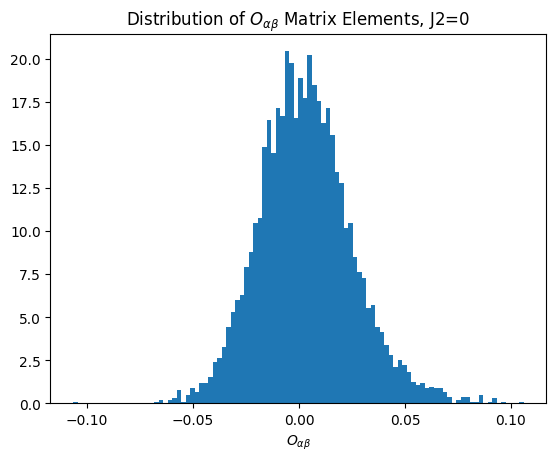

In [ ]:
plt.hist(matElems0, bins=100, density=True)
plt.title(r"Distribution of $O_{\alpha \beta}$ Matrix Elements, J2=0")
plt.xlabel(r'$O_{\alpha \beta}$')

Text(0.5, 0, '$O_{\\alpha \\beta}$')

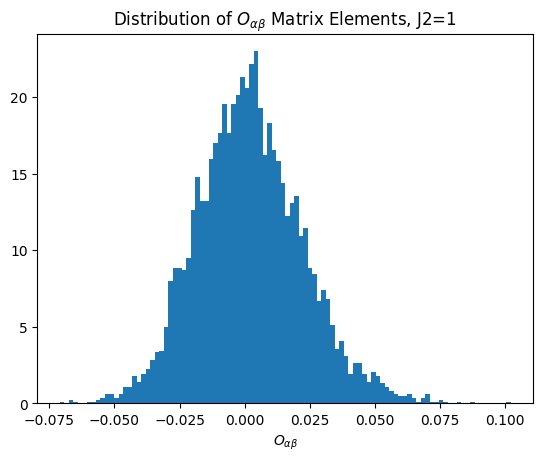

In [ ]:
plt.hist(matElems1, bins=100, density=True)
plt.title(r"Distribution of $O_{\alpha \beta}$ Matrix Elements, J2=1")
plt.xlabel(r'$O_{\alpha \beta}$')

> After 15 minutes of computing, the distributions do look Gaussian!